# Project  ***Movie Analysis***

# 1. Overview

### .......................

## 2. Preprocess the data

In [2]:
# libraries: mathematical computing
import numpy as np
import pandas as pd

# libraries: sklearn
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# libraries: pyspark SparkContext
from pyspark import SparkContext, SparkConf

# libraries: pyspark sql
from pyspark.sql.types import IntegerType, FloatType, DateType
from pyspark.sql.window import Window
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from  pyspark.sql.functions import monotonically_increasing_id, desc, row_number
from pyspark.sql import SQLContext

# libraries: pyspark machine learning
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.functions import vector_to_array
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, DecisionTreeClassifier, NaiveBayes, RandomForestClassificationModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator, RegressionEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
from pyspark.mllib.stat import Statistics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel, TrainValidationSplit,TrainValidationSplitModel
from pyspark.ml.feature import HashingTF, Tokenizer, RFormula
from pyspark.ml.regression import RandomForestRegressor

# libraries: visualization
import seaborn as sb
import matplotlib.pyplot as mpt
import functools
from collections import Counter
from ydata_profiling import ProfileReport


In [7]:
# Spark Builder

spark = SparkSession.builder.appName("movieAnalysis").getOrCreate()

In [8]:
spark

#### Now, let´s convert the .csv files into .parquet because they´re faster to analyze.

In [5]:
# convert the .csv file into .parquet
# table: movieDataset.csv

df = spark.read.csv('movieDataset.csv', header=True)

df.write.parquet('movieDataset.parquet')

df_movies = spark.read.parquet('movieDataset.parquet')

In [11]:
df_movies.show(10)

+------+--------------------+------------+----------+--------+------------+-------+-------+-----+--------------------+------+--------------------+---------+-----------------+--------------------+--------------------+----------+--------------------+--------------------+-------------------+--------------------+--------------------+----------------+--------------------+
|    id|               title|vote_average|vote_count|  status|release_date|revenue|runtime|adult|       backdrop_path|budget|            homepage|  imdb_id|original_language|      original_title|            overview|popularity|         poster_path|             tagline|             genres|production_companies|production_countries|spoken_languages|            keywords|
+------+--------------------+------------+----------+--------+------------+-------+-------+-----+--------------------+------+--------------------+---------+-----------------+--------------------+--------------------+----------+--------------------+------------

In [12]:
df_movies.printSchema()

root
 |-- id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: string (nullable = true)
 |-- vote_count: string (nullable = true)
 |-- status: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: string (nullable = true)
 |-- runtime: string (nullable = true)
 |-- adult: string (nullable = true)
 |-- backdrop_path: string (nullable = true)
 |-- budget: string (nullable = true)
 |-- homepage: string (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- poster_path: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- keywords: string (nullabl

In [13]:
df_movies.count()

1052039

#### Let´s convert the string columns into integer and/or float columns

In [27]:
# convert string columns into integer columns

df_movies = df_movies.withColumn("id",df_movies["id"].cast(IntegerType()))

df_movies = df_movies.withColumn("vote_average",df_movies["vote_average"].cast(IntegerType()))

df_movies = df_movies.withColumn("vote_count",df_movies["vote_average"].cast(IntegerType()))

df_movies = df_movies.withColumn("release_date",df_movies["release_date"].cast(DateType()))

df_movies = df_movies.withColumn("revenue",df_movies["revenue"].cast(IntegerType()))

df_movies = df_movies.withColumn("runtime",df_movies["runtime"].cast(IntegerType()))

df_movies = df_movies.withColumn("budget",df_movies["budget"].cast(IntegerType()))

df_movies = df_movies.withColumn("popularity",df_movies["popularity"].cast(IntegerType()))

In [97]:
df_movies.printSchema()

NameError: name 'df_movies' is not defined

#### Let´s convert the .csv files into .parquet files to analyze the data faster.

In [15]:
# convert the .csv file into .parquet
# table: name.basics.tsv

df_name_basics = spark.read.format('csv').options(inferSchema=True,header = True, sep='\t').load('name.basics.tsv')
df_name_basics.write.parquet('name.basics.parquet')
df_name_basics = spark.read.parquet('name.basics.parquet')

In [27]:
df_name_basics.show(5)

+---------+----------------+---------+---------+--------------------+--------------------+
|   nconst|     primaryName|birthYear|deathYear|   primaryProfession|      knownForTitles|
+---------+----------------+---------+---------+--------------------+--------------------+
|nm1979452|    David Wexler|       \N|       \N|            director|           tt0387729|
|nm1979453|Takeshi Tateishi|       \N|       \N|visual_effects,mi...|tt0208156,tt10951...|
|nm1979454| Rodolfo Wellish|       \N|       \N|               actor|           tt0470111|
|nm1979455|    Glory Friend|       \N|       \N|            producer| tt0455581,tt0133302|
|nm1979456|   Michael Aaron|       \N|       \N|        actor,writer|tt0088568,tt04747...|
+---------+----------------+---------+---------+--------------------+--------------------+
only showing top 5 rows



In [30]:
df_name_basics.count()

13544746

In [20]:
# convert the .csv file into .parquet
# table: title.akas.tsv

df_title_akas = spark.read.format('csv').options(inferSchema=True,header = True, sep='\t').load('title.akas.tsv')
df_title_akas.write.parquet('title.akas.parquet')
df_title_akas = spark.read.parquet('title.akas.parquet')

In [33]:
df_title_akas.show(5)

+---------+--------+--------------------+------+--------+-----------+-------------+---------------+
|  titleId|ordering|               title|region|language|      types|   attributes|isOriginalTitle|
+---------+--------+--------------------+------+--------+-----------+-------------+---------------+
|tt0000001|       1|          Carmencita|    \N|      \N|   original|           \N|              1|
|tt0000001|       2|          Carmencita|    DE|      \N|         \N|literal title|              0|
|tt0000001|       3|          Carmencita|    US|      \N|imdbDisplay|           \N|              0|
|tt0000001|       4|Carmencita - span...|    HU|      \N|imdbDisplay|           \N|              0|
|tt0000001|       5|          Καρμενσίτα|    GR|      \N|imdbDisplay|           \N|              0|
+---------+--------+--------------------+------+--------+-----------+-------------+---------------+
only showing top 5 rows



In [34]:
df_title_akas.printSchema()

root
 |-- titleId: string (nullable = true)
 |-- ordering: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- region: string (nullable = true)
 |-- language: string (nullable = true)
 |-- types: string (nullable = true)
 |-- attributes: string (nullable = true)
 |-- isOriginalTitle: integer (nullable = true)



In [35]:
df_title_akas.count()

48679363

In [21]:
# convert the .csv file into .parquet
# table: title.basics.tsv

df_title_basics = spark.read.format('csv').options(inferSchema=True,header = True, sep='\t').load('title.basics.tsv')
df_title_basics.write.parquet('title.basics.parquet')
df_title_basics = spark.read.parquet('title.basics.parquet')

In [36]:
df_title_basics.show(5)

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|     \N|             1|   Documentary,Short|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|     \N|             5|     Animation,Short|
|tt0000003|    short|      Pauvre Pierrot|      Pauvre Pierrot|      0|     1892|     \N|             5|Animation,Comedy,...|
|tt0000004|    short|         Un bon bock|         Un bon bock|      0|     1892|     \N|            12|     Animation,Short|
|tt0000005|    short|    Blacksmith Scene|    Blacksmith Scene|      0|     1893|     \N|             1|        Comedy

In [37]:
df_title_basics.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: string (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: string (nullable = true)
 |-- genres: string (nullable = true)



In [22]:
# convert the .csv file into .parquet
# table: title.principals.tsv

df_title_principals = spark.read.format('csv').options(inferSchema=True,header = True, sep='\t').load('title.principals.tsv')
df_title_principals.write.parquet('title.principals.parquet')
df_title_principals = spark.read.parquet('title.principals.parquet')

In [38]:
df_title_principals.show(5)

+---------+--------+---------+---------------+--------------------+----------+
|   tconst|ordering|   nconst|       category|                 job|characters|
+---------+--------+---------+---------------+--------------------+----------+
|tt0000001|       1|nm1588970|           self|                  \N|  ["Self"]|
|tt0000001|       2|nm0005690|       director|                  \N|        \N|
|tt0000001|       3|nm0005690|       producer|            producer|        \N|
|tt0000001|       4|nm0374658|cinematographer|director of photo...|        \N|
|tt0000002|       1|nm0721526|       director|                  \N|        \N|
+---------+--------+---------+---------------+--------------------+----------+
only showing top 5 rows



In [39]:
df_title_principals.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- ordering: integer (nullable = true)
 |-- nconst: string (nullable = true)
 |-- category: string (nullable = true)
 |-- job: string (nullable = true)
 |-- characters: string (nullable = true)



In [41]:
df_title_principals.count()

86327850

In [24]:
# convert the .csv file into .parquet
# table: title.ratings.tsv

df_title_ratings = spark.read.format('csv').options(inferSchema=True,header = True, sep='\t').load('title.ratings.tsv')
df_title_ratings.write.parquet('title.ratings.parquet')
df_title_ratings = spark.read.parquet('title.ratings.parquet')

In [42]:
df_title_ratings.show(5)

+---------+-------------+--------+
|   tconst|averageRating|numVotes|
+---------+-------------+--------+
|tt0000001|          5.7|    2059|
|tt0000002|          5.6|     277|
|tt0000003|          6.5|    2023|
|tt0000004|          5.3|     180|
|tt0000005|          6.2|    2787|
+---------+-------------+--------+
only showing top 5 rows



In [43]:
df_title_ratings.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- averageRating: double (nullable = true)
 |-- numVotes: integer (nullable = true)



In [44]:
df_title_ratings.count()

1446041

### 2.1 Future Engineering

In [45]:
# table: name_basics

df_name_basics.show(5)

+---------+----------------+---------+---------+--------------------+--------------------+
|   nconst|     primaryName|birthYear|deathYear|   primaryProfession|      knownForTitles|
+---------+----------------+---------+---------+--------------------+--------------------+
|nm1979452|    David Wexler|       \N|       \N|            director|           tt0387729|
|nm1979453|Takeshi Tateishi|       \N|       \N|visual_effects,mi...|tt0208156,tt10951...|
|nm1979454| Rodolfo Wellish|       \N|       \N|               actor|           tt0470111|
|nm1979455|    Glory Friend|       \N|       \N|            producer| tt0455581,tt0133302|
|nm1979456|   Michael Aaron|       \N|       \N|        actor,writer|tt0088568,tt04747...|
+---------+----------------+---------+---------+--------------------+--------------------+
only showing top 5 rows



#### Let´s drop off some columns that are unnecessary.

In [50]:
df_name_basics = df_name_basics.drop('birthYear','deathYear','primaryProfession')

In [51]:
df_name_basics.show(5)

+---------+----------------+--------------------+
|   nconst|     primaryName|      knownForTitles|
+---------+----------------+--------------------+
|nm1979452|    David Wexler|           tt0387729|
|nm1979453|Takeshi Tateishi|tt0208156,tt10951...|
|nm1979454| Rodolfo Wellish|           tt0470111|
|nm1979455|    Glory Friend| tt0455581,tt0133302|
|nm1979456|   Michael Aaron|tt0088568,tt04747...|
+---------+----------------+--------------------+
only showing top 5 rows



In [46]:
# table: title_akas

df_title_akas.show(5)

+---------+--------+--------------------+------+--------+-----------+-------------+---------------+
|  titleId|ordering|               title|region|language|      types|   attributes|isOriginalTitle|
+---------+--------+--------------------+------+--------+-----------+-------------+---------------+
|tt0000001|       1|          Carmencita|    \N|      \N|   original|           \N|              1|
|tt0000001|       2|          Carmencita|    DE|      \N|         \N|literal title|              0|
|tt0000001|       3|          Carmencita|    US|      \N|imdbDisplay|           \N|              0|
|tt0000001|       4|Carmencita - span...|    HU|      \N|imdbDisplay|           \N|              0|
|tt0000001|       5|          Καρμενσίτα|    GR|      \N|imdbDisplay|           \N|              0|
+---------+--------+--------------------+------+--------+-----------+-------------+---------------+
only showing top 5 rows



#### Let´s drop off some columns that are unnecessary.

In [57]:
df_title_akas = df_title_akas.drop('language','types','attributes')

df_title_akas.show(5)

In [71]:
df_title_akas.show(5)

+---------+--------+--------------------+------+---------------+
|  titleId|ordering|               title|region|isOriginalTitle|
+---------+--------+--------------------+------+---------------+
|tt0000001|       1|          Carmencita|    \N|              1|
|tt0000001|       2|          Carmencita|    DE|              0|
|tt0000001|       3|          Carmencita|    US|              0|
|tt0000001|       4|Carmencita - span...|    HU|              0|
|tt0000001|       5|          Καρμενσίτα|    GR|              0|
+---------+--------+--------------------+------+---------------+
only showing top 5 rows



In [58]:
df_title_akas.createOrReplaceTempView('title_akas')

In [62]:
results = spark.sql('''select * from title_akas''')

In [63]:
results.show()

+---------+--------+--------------------+------+---------------+
|  titleId|ordering|               title|region|isOriginalTitle|
+---------+--------+--------------------+------+---------------+
|tt0000001|       1|          Carmencita|    \N|              1|
|tt0000001|       2|          Carmencita|    DE|              0|
|tt0000001|       3|          Carmencita|    US|              0|
|tt0000001|       4|Carmencita - span...|    HU|              0|
|tt0000001|       5|          Καρμενσίτα|    GR|              0|
|tt0000001|       6|          Карменсита|    RU|              0|
|tt0000001|       7|          Карменсіта|    UA|              0|
|tt0000001|       8|      カルメンチータ|    JP|              0|
|tt0000002|       1|Le clown et ses c...|    \N|              1|
|tt0000002|       2|   A bohóc és kutyái|    HU|              0|
|tt0000002|       3|Clovnul si cainii...|    RO|              0|
|tt0000002|       4|Der Clown und sei...|    DE|              0|
|tt0000002|       5|Le clown et 

In [64]:
results.count()

48679363

In [47]:
# table: title_ratings

df_title_ratings.show(5)

+---------+-------------+--------+
|   tconst|averageRating|numVotes|
+---------+-------------+--------+
|tt0000001|          5.7|    2059|
|tt0000002|          5.6|     277|
|tt0000003|          6.5|    2023|
|tt0000004|          5.3|     180|
|tt0000005|          6.2|    2787|
+---------+-------------+--------+
only showing top 5 rows



In [65]:
df_title_ratings = df_title_ratings.withColumnRenamed('tconst','titleId')

df_title_ratings.show(5)

In [66]:
df_title_ratings.show(5)

+---------+-------------+--------+
|  titleId|averageRating|numVotes|
+---------+-------------+--------+
|tt0000001|          5.7|    2059|
|tt0000002|          5.6|     277|
|tt0000003|          6.5|    2023|
|tt0000004|          5.3|     180|
|tt0000005|          6.2|    2787|
+---------+-------------+--------+
only showing top 5 rows



In [84]:
df_title_ratings.count()

1446041

In [85]:
df_title_ratings.createOrReplaceTempView('ratings')

In [86]:
results = spark.sql('select AVG(averageRating) AS total_avg_rating from ratings')

results.show(5)

+------------------+
|  total_avg_rating|
+------------------+
|6.9615692777728935|
+------------------+



In [48]:
# table: title_principals

df_title_principals.show(5)

+---------+--------+---------+---------------+--------------------+----------+
|   tconst|ordering|   nconst|       category|                 job|characters|
+---------+--------+---------+---------------+--------------------+----------+
|tt0000001|       1|nm1588970|           self|                  \N|  ["Self"]|
|tt0000001|       2|nm0005690|       director|                  \N|        \N|
|tt0000001|       3|nm0005690|       producer|            producer|        \N|
|tt0000001|       4|nm0374658|cinematographer|director of photo...|        \N|
|tt0000002|       1|nm0721526|       director|                  \N|        \N|
+---------+--------+---------+---------------+--------------------+----------+
only showing top 5 rows



#### Let´s rename a column.

In [67]:
df_title_principals = df_title_principals.withColumnRenamed('tconst','titleId')

df_title_principals.show(5)

In [72]:
df_title_principals.show(5)

+---------+--------+---------+---------------+--------------------+----------+
|  titleId|ordering|   nconst|       category|                 job|characters|
+---------+--------+---------+---------------+--------------------+----------+
|tt0000001|       1|nm1588970|           self|                  \N|  ["Self"]|
|tt0000001|       2|nm0005690|       director|                  \N|        \N|
|tt0000001|       3|nm0005690|       producer|            producer|        \N|
|tt0000001|       4|nm0374658|cinematographer|director of photo...|        \N|
|tt0000002|       1|nm0721526|       director|                  \N|        \N|
+---------+--------+---------+---------------+--------------------+----------+
only showing top 5 rows



#### Let´s drop off some columns that are unnecessary.

In [73]:
df_title_principals = df_title_principals.drop('characters')

In [74]:
df_title_principals.show(5)

+---------+--------+---------+---------------+--------------------+
|  titleId|ordering|   nconst|       category|                 job|
+---------+--------+---------+---------------+--------------------+
|tt0000001|       1|nm1588970|           self|                  \N|
|tt0000001|       2|nm0005690|       director|                  \N|
|tt0000001|       3|nm0005690|       producer|            producer|
|tt0000001|       4|nm0374658|cinematographer|director of photo...|
|tt0000002|       1|nm0721526|       director|                  \N|
+---------+--------+---------+---------------+--------------------+
only showing top 5 rows



In [87]:
df_title_principals.createOrReplaceTempView('principals')

In [89]:
join = spark.sql('select averageRating,genre from ratings as r INNER JOIN principals p ON r.titleId = p.titleId')

In [ ]:
join.show(5)

In [95]:
join = spark.sql('select title,averageRating from title_akas AS a INNER JOIN ratings r ON a.titleId = r.titleId')

In [96]:
join.show(5)

+--------------------+-------------+
|               title|averageRating|
+--------------------+-------------+
|          Carmencita|          5.7|
|          Carmencita|          5.7|
|          Carmencita|          5.7|
|Carmencita - span...|          5.7|
|          Καρμενσίτα|          5.7|
+--------------------+-------------+
only showing top 5 rows



In [49]:
# table: title_basics

df_title_basics.show(5)

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|     \N|             1|   Documentary,Short|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|     \N|             5|     Animation,Short|
|tt0000003|    short|      Pauvre Pierrot|      Pauvre Pierrot|      0|     1892|     \N|             5|Animation,Comedy,...|
|tt0000004|    short|         Un bon bock|         Un bon bock|      0|     1892|     \N|            12|     Animation,Short|
|tt0000005|    short|    Blacksmith Scene|    Blacksmith Scene|      0|     1893|     \N|             1|        Comedy

In [80]:
df_title_basics = df_title_basics.withColumnRenamed('tconst','titleId')

df_title_basics.show(5)

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|  titleId|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|     \N|             1|   Documentary,Short|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|     \N|             5|     Animation,Short|
|tt0000003|    short|      Pauvre Pierrot|      Pauvre Pierrot|      0|     1892|     \N|             5|Animation,Comedy,...|
|tt0000004|    short|         Un bon bock|         Un bon bock|      0|     1892|     \N|            12|     Animation,Short|
|tt0000005|    short|    Blacksmith Scene|    Blacksmith Scene|      0|     1893|     \N|             1|        Comedy

#### Let´s drop off a column.

In [81]:
df_title_basics = df_title_basics.drop('originalTitle')

In [82]:
df_title_basics.show(5)

+---------+---------+--------------------+-------+---------+-------+--------------+--------------------+
|  titleId|titleType|        primaryTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000001|    short|          Carmencita|      0|     1894|     \N|             1|   Documentary,Short|
|tt0000002|    short|Le clown et ses c...|      0|     1892|     \N|             5|     Animation,Short|
|tt0000003|    short|      Pauvre Pierrot|      0|     1892|     \N|             5|Animation,Comedy,...|
|tt0000004|    short|         Un bon bock|      0|     1892|     \N|            12|     Animation,Short|
|tt0000005|    short|    Blacksmith Scene|      0|     1893|     \N|             1|        Comedy,Short|
+---------+---------+--------------------+-------+---------+-------+--------------+--------------------+
only showing top 5 rows



In [ ]:
df_title_basics

## 3. Exploratory Data Analysis (EDA)

In [25]:
# definition of the "histogram" function

def histogram(df, col, bins=10, xname=None, yname=None):
    
    '''
    This function makes a histogram from spark dataframe named 
    df for column name col. 
    '''
    
    # Calculating histogram in Spark 
    vals = df.select(col).rdd.flatMap(lambda x: x).histogram(bins)

    # Preprocessing histogram points and locations 
    width = vals[0][1] - vals[0][0]
    loc = [vals[0][0] + (i+1) * width for i in range(len(vals[1]))]
    
    # Making a bar plot 
    mpt.bar(loc, vals[1], width=width)
    mpt.xlabel(col)
    mpt.ylabel(yname)
    mpt.show()

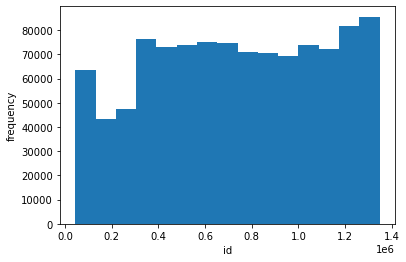

In [29]:
histogram(df_movies,'id',bins=15, yname='frequency')

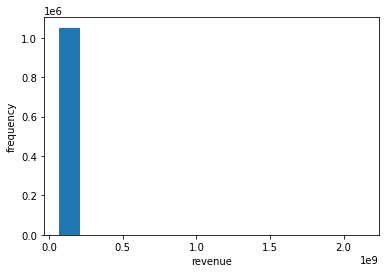

In [39]:
histogram(df_movies,'revenue',bins=15, yname='frequency')

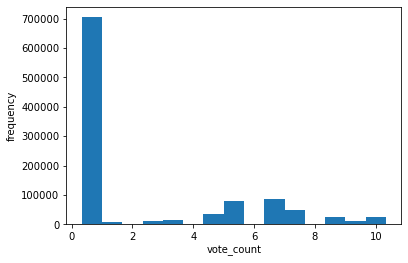

In [43]:
histogram(df_movies,'vote_count',bins=15, yname='frequency')

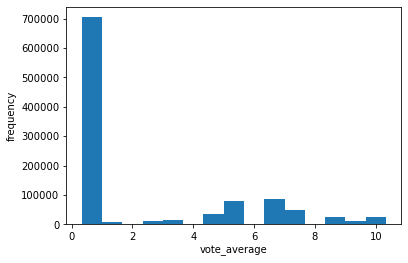

In [44]:
histogram(df_movies,'vote_average',bins=15, yname='frequency')

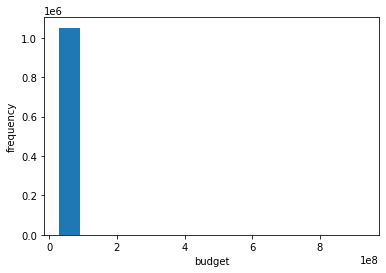

In [45]:
histogram(df_movies,'budget',bins=15, yname='frequency')

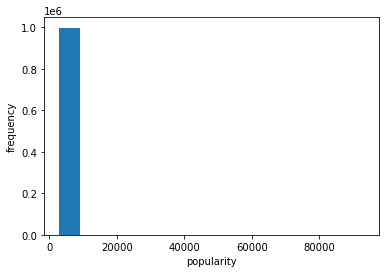

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 50825)
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/anaconda3/lib/python3.11/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/opt/anaconda3/lib/python3.11/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/anaconda3/lib/python3.11/socketserver.py", line 755, in __init__
    self.handle()
  File "/opt/anaconda3/lib/python3.11/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/opt/anaconda3/lib/python3.11/site-packages/pyspark/accumulators.py", line 267, in poll
    if self.rfile in r and func():
                           ^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-pac

In [46]:
histogram(df_movies,'popularity',bins=15, yname='frequency')

## 4. Business Questions

## First question: ***What is the evolution of the rating per content?***

## Second question: ***What is the average rating per genre?***

## Third question: ***What are the genres which provide the highest ROI?***

## Fourth question: ***What are the countries with the highest production of content?***

## Fifth question: ***What is your recommendation for the client?***